# MSBD 566 - Lecture 9
## Clustering - Mean Shift

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Make data

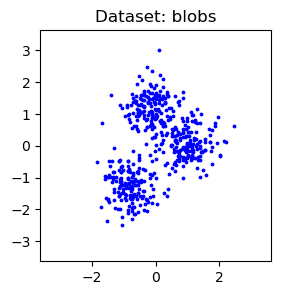

In [2]:
from sklearn.datasets import make_blobs, make_classification, make_moons, make_circles

dataset_type = 'blobs'  # try: blobs, classification, moons, circles, anisotropic, varied

if dataset_type == 'blobs':
    X1, _ = make_blobs(
        n_samples=500,
        centers=3,
        cluster_std=3,
        random_state=42
    )

elif dataset_type == 'classification':
    X1, _ = make_classification(
        n_samples=120,
        n_features=2,
        n_redundant=0,
        n_clusters_per_class=1,
        n_classes=3,
        class_sep=2,
        random_state=42
    )

elif dataset_type == 'moons':
    from sklearn.datasets import make_moons
    X1, _ = make_moons(
        n_samples=120,
        noise=0.1,
        random_state=42
    )

elif dataset_type == 'circles':
    from sklearn.datasets import make_circles
    X1, _ = make_circles(
        n_samples=500,
        noise=0.05,
        factor=0.5,
        random_state=42
    )

elif dataset_type == 'anisotropic':
    X1, _ = make_blobs(
        n_samples=120,
        centers=3,
        cluster_std=1,
        random_state=42
    )
    # Apply an anisotropic linear transformation
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X1 = X1.dot(transformation)

elif dataset_type == 'varied':
    X1, _ = make_blobs(
        n_samples=120,
        centers=[[-5, -5], [0, 0], [5, 5]],
        cluster_std=[1.0, 2.5, 0.5],
        random_state=42
    )

else:
    raise ValueError("Unknown dataset_type")

# Normalize and add optional noise
n_noise = 0
X1 -= np.mean(X1, axis=0)
MAX = np.max(np.abs(X1))
X2 = np.random.uniform(-MAX, MAX, size=(n_noise, 2))

X = np.concatenate((X1, X2), axis=0)
X -= np.mean(X, axis=0)
X /= np.std(X)
MAX = np.max(np.abs(X)) * 1.2

# Plot the data
plt.figure(figsize=(3, 3))
plt.scatter(X[:, 0], X[:, 1], c='b', s=3)
plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.gca().set_aspect('equal')
plt.title(f"Dataset: {dataset_type}")
plt.show()

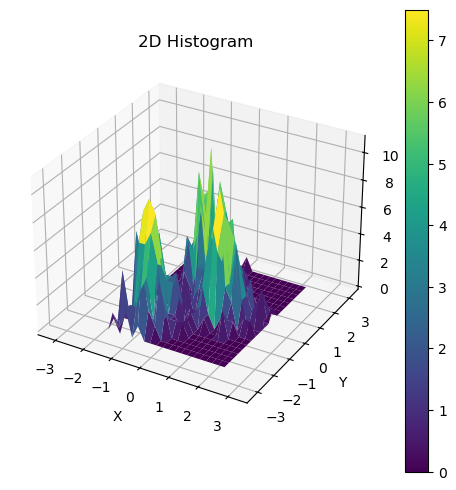

In [3]:
# Just to visualize the density, we create a histogram

# Calculate 2D histogram
hist, xedges, yedges = np.histogram2d(X[:,0], X[:,1], bins=20)

# Construct arrays for the X-Y edges
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")

# Create 3D plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D surface
surf = ax.plot_surface(xpos, ypos, hist, cmap='viridis')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-MAX, MAX)
ax.set_ylim(-MAX, MAX)
ax.set_zlabel('Frequency')
ax.set_title('2D Histogram')

# Add color bar
fig.colorbar(surf)

plt.show()

### MeanShift Clustering in-depth

##### How Mean Shift Clustering Works (Mathematical Explanation)

Mean Shift is a **mode-seeking algorithm** that iteratively shifts *kernel centers* toward the nearest high-density region.  
**The data points do not move** — they define the density landscape.

---

**1. Kernel Density Estimate (KDE)**

At its core, Mean Shift uses a kernel to estimate the local probability density function (PDF) around each point.

The multivariate KDE at point $\mathbf{x}$ is:

$$
\hat{f}(\mathbf{x}) = \frac{1}{n h^d} \sum_{i=1}^n K\!\Big(\frac{\mathbf{x} - \mathbf{x}_i}{h}\Big)
$$

- $n$ = number of data points  
- $h$ = bandwidth (kernel size)  
- $d$ = number of dimensions  
- $K(\cdot)$ = kernel function (e.g., Gaussian, flat)

---

**2. The Mean Shift Vector**

The **mean shift vector** is the gradient of the density estimate — it points toward the direction of **maximum increase in density**.

At a point $\mathbf{x}$:

$$
\mathbf{m}(\mathbf{x}) = \frac{ \sum_{i=1}^n \mathbf{x}_i \, K\!\Big(\frac{\mathbf{x} - \mathbf{x}_i}{h}\Big) }{ \sum_{i=1}^n K\!\Big(\frac{\mathbf{x} - \mathbf{x}_i}{h}\Big) } - \mathbf{x}
$$

So, it’s the difference between the **weighted mean of nearby points** and the current position.

---

**3. Iterative Update**

Given a starting point $\mathbf{x}^{(t)}$ (the kernel center):

$$
\mathbf{x}^{(t+1)} = \mathbf{x}^{(t)} + \mathbf{m}(\mathbf{x}^{(t)})
$$

Equivalently:

$$
\mathbf{x}^{(t+1)} = \frac{ \sum_{i=1}^n \mathbf{x}_i \, K\!\Big(\frac{\mathbf{x}^{(t)} - \mathbf{x}_i}{h}\Big) }{ \sum_{i=1}^n K\!\Big(\frac{\mathbf{x}^{(t)} - \mathbf{x}_i}{h}\Big) }
$$

This means the kernel center shifts to the **weighted mean** of the data points inside its window.

---

**4. Convergence**

The mean shift process repeats until the shift vector $\mathbf{m}(\mathbf{x})$ is very small:

$$
\|\mathbf{m}(\mathbf{x})\| < \epsilon
$$

for some small threshold $\epsilon$.

### Using Mean Shift Clustering in scikit-learn

**Important Parameters**

**bandwidth**  
The `bandwidth` parameter defines the radius of the kernel window used for shifting. A small bandwidth finds fine-grained clusters, while a large bandwidth merges clusters into larger groups. If you do not specify a bandwidth, scikit-learn can estimate a good starting value automatically using a built-in heuristic.

**bin_seeding**  
This parameter, when set to true, uses an initial coarse grid of seed points rather than starting with every data point. This speeds up convergence, especially for large datasets.

**cluster_all**  
This parameter determines whether all data points must be assigned to a cluster. If true (the default), every point is clustered. If false, points that do not fall within any kernel window are marked as noise and labeled as -1.

**What You Get After Fitting**

After running Mean Shift, the fitted model provides:

- Cluster labels for each sample in the data.
- The coordinates of the cluster centers that represent the detected modes.
- The total number of clusters found by the algorithm.

**Practical Tips**

- The default kernel in scikit-learn’s Mean Shift is a flat kernel.
- Mean Shift can be computationally expensive for large datasets, so using `bin_seeding` or subsampling can help.
- Selecting a good bandwidth is crucial for meaningful clustering results. You can experiment with different values or use scikit-learn’s automatic bandwidth estimation as a starting point.

In [4]:
from sklearn.cluster import MeanShift

# Important Parameters
bandwidth = 0.4
model = MeanShift(bandwidth=bandwidth)

# Fit the model and predict cluster labels
model.fit(X)
labels = model.predict(X)

# print the results
print("Number of clusters found:", len(np.unique(labels)))
print(labels)

# print cluster centers
print("Cluster centers:\n", model.cluster_centers_)

Number of clusters found: 14
[ 6  4  5  3  2  2  6  2  4  0  2  3  2  1  5  2  1  0  0  3  4  4  2  6
  0  2  3  0  0  1  2  7  1  1  2  2  2  4  0  0  4  3  1  3  3  5  2  2
  2  0 12  7  0  0  5  1  3  0  2 12 10  1  2  0  2 10  2 12  3  2  2  2
  5  0  1 10  3  2  3  3  0  1  2  1  0 12 10  4  2  3  0  5  3  2  2 12
  7  1  7  0  2  1  3 10  0  3  1 12 11  0  0  0 10  0  0  3  1  0  4  0
  3  3  2  2  4  5  1  2  0  0  0  2  4  0  2  0  0  0  4  1  0  6  5  2
  0  0  0  1  3  3  2  0  2  3  1  0  3  0  2  2  6  0  3  1  0  1  1  5
  0  0  0  1  3  0  0  1  7  4  2  5  7  0  3  3  6  0  7  5  3  0  0 10
  0 12  1  2  1  1 10  2  1  3  4  0  2  0  4  1  1  0  6  5  6  1  1 12
  1  0  3  2  3  1  0  1  2  1  1  0  2  2  2  4  3  0  0  0  7  2  1  2
  2  4  1  3  0  0  2  7  3  2  3  3  3  3  6  1  0  3  4  1  9  1  0  1
  2  2  2  1  2  2  1  1  2  6  1 11 11  3  0  0  3  2  3  1 12  3  2  0
  4  2  0  7 13  3  0 13  0  3  2  3  2  0  5  2  3  5  2  2  4  3  5  0
  2  5  2 10  0  5  2 

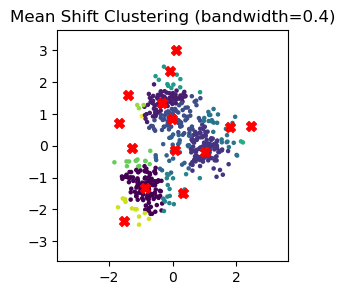

In [5]:
# Plot the clustered data
plt.figure(figsize=(3, 3))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=5)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='red', s=50, marker='X')  # Mark cluster centers
plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.gca().set_aspect('equal')
plt.title(f"Mean Shift Clustering (bandwidth={bandwidth})")
plt.show()

In [6]:
# Let's try to estimate the bandwidth using the built-in function
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.2)
print("Estimated bandwidth:", bandwidth)

Estimated bandwidth: 0.8356484746657918


Number of clusters found with estimated bandwidth: 3


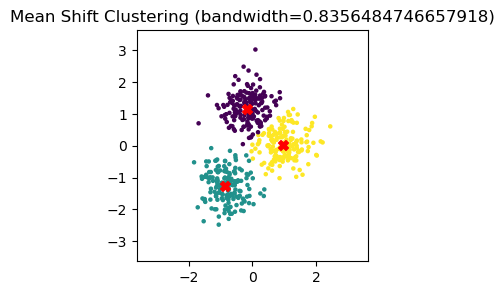

In [7]:
# recalculate with new bandwidth
modelNew = MeanShift(bandwidth=bandwidth)
modelNew.fit(X)
labelsNew = modelNew.predict(X)
print("Number of clusters found with estimated bandwidth:", len(np.unique(labelsNew)))

# Plot the clustered data
plt.figure(figsize=(3, 3))
plt.scatter(X[:, 0], X[:, 1], c=labelsNew, s = 5)
plt.scatter(modelNew.cluster_centers_[:, 0], modelNew.cluster_centers_[:, 1], c='red', s=50, marker='X')  # Mark cluster centers
plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.gca().set_aspect('equal')
plt.title(f"Mean Shift Clustering (bandwidth={bandwidth})")
plt.show()

### Cluster Stability & Agreement Demo

In real-world clustering, we often want to check **how stable** or **consistent** our clusters are across different methods or parameter settings.

One simple approach is to run multiple clustering algorithms (or the same algorithm with different `k` or distance thresholds) and compare how often pairs of points get assigned to the **same cluster**.

In this demo, we:
- Run several clustering variants (K-Means with different `k`, GMM).
- For each pair of points, count how many times they co-occur in the same cluster.
- Visualize the **agreement matrix** as a heatmap to see which regions of the dataset are robustly grouped together.

This teaches how to **test cluster robustness** and **explore consensus** across methods.


When you run two different clustering models (or the same model with different settings), it’s helpful to check **how their cluster assignments agree**.

A **cross-tabulation** (contingency table) counts how many points from each cluster in `model1` overlap with each cluster in `model2`.  
This shows:
- Which clusters align well across runs.
- Whether clusters split or merge when parameters change.
- How stable or unstable your clusters are.

It’s a simple but powerful way to **diagnose clustering consistency** — especially when you don’t have ground truth labels!

Let's create a plot function to ease us so we don't have to repeat the same lines

In [8]:
def plot_regions(model):
    
    nGrid = 200
    a1 = np.linspace(-MAX,MAX,nGrid)
    a2 = np.linspace(-MAX,MAX,nGrid)
    
    A1, A2 = np.meshgrid(a1,a2)
    A1 = A1.flatten()
    A2 = A2.flatten()
    A = np.vstack((A1,A2)).T
    
    B = model.predict(A)
    B = B.reshape(nGrid,nGrid)
    B = np.flipud(B)
    
    return B

**Run method 1: kmeans**

In [9]:
from sklearn.cluster import KMeans

model1 = KMeans(n_clusters=3)
model1.fit(X)
labels1 = model1.predict(X)

**Run method 2: GMM**

In [10]:
from sklearn.mixture import GaussianMixture as GMM

model2 = GMM(n_components=3)
model2.fit(X)
labels2 = model2.predict(X)

**Create cross-tab of cluster assignments**

model2,0,1,2
model1,,,
0,0,0,170
1,165,2,0
2,0,163,0


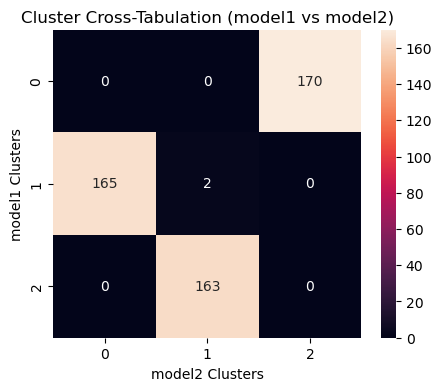

In [11]:
df = pd.DataFrame({
    'model1': labels1,
    'model2': labels2,
})
ctab = pd.crosstab(df['model1'], df['model2'])

# just display the cross-table
display(ctab)
# or plot a heatmap - which looks cooler
plt.figure(figsize=(5, 4))
sns.heatmap(ctab, annot=True, square=True, fmt='d')
plt.title("Cluster Cross-Tabulation (model1 vs model2)")
plt.xlabel("model2 Clusters")
plt.ylabel("model1 Clusters")
plt.show()

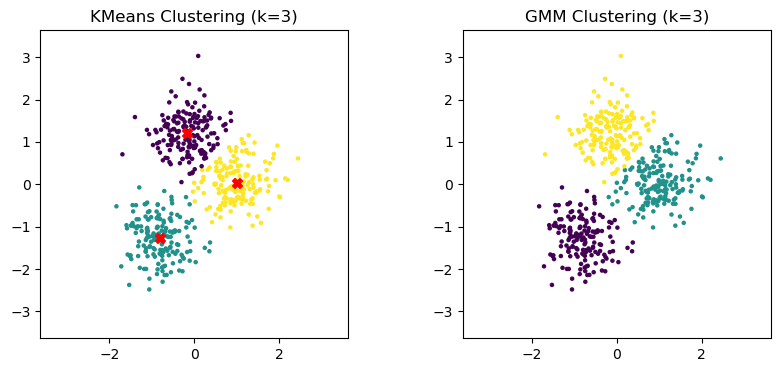

In [12]:
# plot the data for both models side by side to compare 
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels1, s=5)
plt.scatter(model1.cluster_centers_[:, 0], model1.cluster_centers_[:, 1], c='red', s=50, marker='X')  # Mark cluster centers
plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.gca().set_aspect('equal')
plt.title(f"KMeans Clustering (k=3)")
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels2, s=5)
plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.gca().set_aspect('equal')
plt.title(f"GMM Clustering (k=3)")
plt.show()

# Consensus Clustering
# ----------------------------------------
# One challenge with clustering is that the results can be sensitive to the choice of algorithm and its parameters.
# ----------------------------------------
# A robust clustering should yield similar groupings even when the method or parameters change slightly.
# ----------------------------------------
# A simple approach is to run multiple clustering algorithms (or the same algorithm with different `k` or distance thresholds) and compare how often pairs of points get assigned to the **same cluster**.

Note: There is a possibility that the cluster numbers are switched, depending on the methods and which points are assigned first. So you might want to switch the numbers and compare again.

As seen on the plot above, the green and purple clusters are switched.

model2,0,1,2
model1,,,
0,0,0,170
1,2,165,0
2,163,0,0


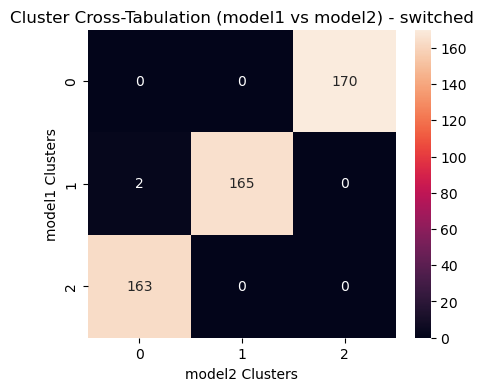

In [13]:
# if you want, we can switch the labels zero to 1 in model 2
labels2_switched = np.where(labels2 == 0, 1, np.where(labels2 == 1, 0, labels2))

# recalculate the cross-tab with switched labels
df_switched = pd.DataFrame({
    'model1': labels1,
    'model2': labels2_switched,
})
ctab_switched = pd.crosstab(df_switched['model1'], df_switched['model2'])
# just display the cross-table
display(ctab_switched)
# or plot a heatmap - which looks cooler
plt.figure(figsize=(5, 4))
sns.heatmap(ctab_switched, annot=True, square=True, fmt='d')
plt.title("Cluster Cross-Tabulation (model1 vs model2) - switched")
plt.xlabel("model2 Clusters")
plt.ylabel("model1 Clusters")
plt.show()

### Resampling-Based Cluster Stability

One practical way to test **cluster stability** is to run the same clustering algorithm many times on slightly different versions of your dataset.

**Two common ways:**
- **Subsampling:** Randomly pick a fraction (e.g., 80%) of the data each time.
- **Bootstrapping:** Sample *with replacement* so the new sample is the same size as the original (some points repeated, some missing).

For each run:
- Fit K-Means (or other method).
- Record which pairs of points end up in the same cluster.
- Average over runs → you get a **co-occurrence matrix** that shows how consistently pairs of points are grouped together.
- Use matrix for precomputed spectral clustering

Interpreting results:
- Co-occurrence values close to 1 means the points are usually clustered together
- Values close to 0 means the points are usually NOT clustered together
- Values near 0.5 are uncertain and can go either way

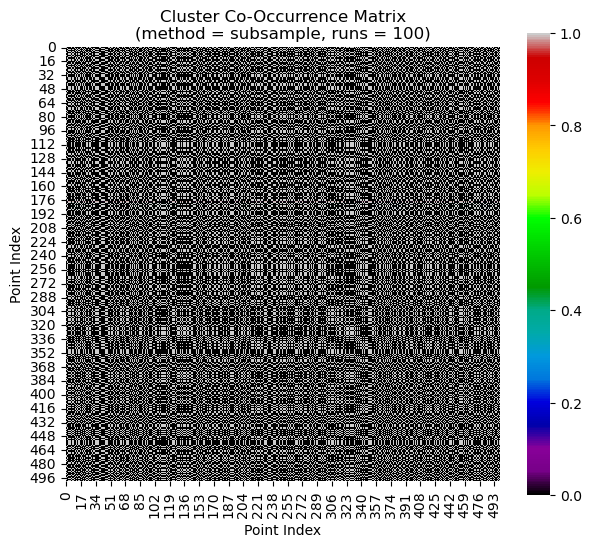

In [14]:
# --------------------------------
# Build co-occurrence matrix + store all labels
# --------------------------------
N = X.shape[0]

# Parameters
n_clusters = 3
n_runs = 100
method = 'subsample'
subsample_frac = 0.8

co_matrix = np.zeros((N, N)) # initialize co-occurrence matrix
labels_runs = [] # to store all labels from each run
rng = np.random.default_rng(42) # for reproducibility

for run in range(n_runs):

    # Create resampled dataset
    if method == 'subsample':
        indices = rng.choice(N, size=int(N * subsample_frac), replace=False)
    elif method == 'bootstrap':
        indices = rng.choice(N, size=N, replace=True)
    else:
        raise ValueError("method must be 'subsample' or 'bootstrap'")

    # new variable to hold the resampled data based on indices
    X_resample = X[indices]

    # Fit clustering model on resampled data
    model = KMeans(n_clusters=n_clusters, random_state=0)
    model.fit(X_resample)

    # Predict for all points
    labels_full = model.predict(X)
    labels_runs.append(labels_full)

    # Update co-occurrence for all pairs once (upper triangle)
    for i in range(N):
        for j in range(i + 1, N):
            if labels_full[i] == labels_full[j]:
                co_matrix[i, j] += 1
                co_matrix[j, i] += 1  # mirror

    # Also count self-coincidence
    co_matrix[np.arange(N), np.arange(N)] += 1

co_matrix /= n_runs # normalize to [0, 1]

# Show heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(co_matrix, square=True, vmin=0, vmax=1, cmap='nipy_spectral')
plt.title(f"Cluster Co-Occurrence Matrix\n(method = {method}, runs = {n_runs})")
plt.xlabel("Point Index")
plt.ylabel("Point Index")
plt.show()

# In this heatmap, most of them are black and white. This means that most of the points are either always clustered together (white) or never clustered together (black) across the multiple runs. This indicates a high level of stability in the clustering results, as the same pairs of points consistently end up in the same clusters regardless of the specific run or subsampling.

# If we have different colors (not just black and white), it indicates that some pairs of points are inconsistently clustered together across different runs. This suggests that the clustering results are less stable, as the same pairs of points do not consistently end up in the same clusters. The presence of various shades of gray or colors in the heatmap reflects this variability in clustering assignments, indicating that the clustering method may be sensitive to the choice of parameters or the specific subset of data used in each run.